In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat
from uncertainties import unumpy
from scipy.optimize import curve_fit

%config InlineBackend.figure_format = 'svg'

In [2]:
paths_1 = ['datafiles/head_angle_'+str(i+1) for i in range(9)]
paths_2 = ['datafiles/f_head_angle_'+str(i+1) for i in range(6)]

In [3]:
codes_to_speeds = {'3':ufloat(3.75, 0.2), '4':ufloat(5.78, 0.2), '4a':ufloat(6.48, 0.2), '5':ufloat(7.79, 0.2),
                  '5a':ufloat(8.35, 0.2), '5b':ufloat(12.3, 0.2), '6':ufloat(14.0, 0.2), '7':ufloat(19.0, 0.2),
                   '8':ufloat(21.1, 0.2), '9':ufloat(23.2, 0.2), '10':ufloat(23.7, 0.2), '11':ufloat(24.2, 0.2),
                   '13':ufloat(25.0, 0.2)}                   

# Open up Data

Open up datafiles from each 10 second run and compute the mean and standard deviation for drag/lifting force. Each set of tests for a particular object (i.e testing a bunch of different wind speeds) is intended to be stored in a single DataFrame.

In [4]:
def get_data(path):
    speed_codes = np.array([])
    lift_means = np.array([]); lift_stds = np.array([])
    drag_means = np.array([]); drag_stds = np.array([])
    for filename in os.listdir(path):
        df = pd.read_csv(path+'/'+filename, sep='\t', skiprows=5, index_col=0).astype(float) 
        speed_codes = np.append(speed_codes, filename[5:-4])
        lift_means = np.append(lift_means,  df['Lift (N)'].mean())
        lift_stds = np.append(lift_stds, df['Lift (N)'].std())
        drag_means = np.append(drag_means, df['Drag (N)'].mean())
        drag_stds = np.append(drag_stds, df['Drag (N)'].std())

    speeds = np.array([codes_to_speeds[speed_code] for speed_code in speed_codes])
    df =  pd.DataFrame({'speed_means': unumpy.nominal_values(speeds), 'speed_stds': unumpy.std_devs(speeds),
                         'lift_means':lift_means, 'lift_stds': lift_stds, 'drag_means':drag_means,
                         'drag_stds':drag_stds})
    
    return df.sort_values('speed_means')

Get the DataFrames.

In [5]:
arm_runs = [get_data(path) for path in paths_1]
no_arm_runs = [get_data(path) for path in paths_2]

In [6]:
display(arm_runs[0].head())

,speed_means,speed_stds,lift_means,lift_stds,drag_means,drag_stds
6,3.75,0.2,-0.000172,0.001323,0.010679,0.002435
4,5.78,0.2,-0.000843,0.002773,0.023265,0.004786
1,6.48,0.2,-0.001353,0.003814,0.041929,0.006591
3,7.79,0.2,-0.000511,0.003995,0.055563,0.007909
7,8.35,0.2,-0.001928,0.006162,0.074888,0.009502


# Fit All The Drag Forces To Quadratic Curves

In [7]:
def quad(x, a):
    return a*x**2

quad_params stores the values of $a$ for $F=av^2$ for each case of the head where $F$ is the drag force and $v$ is the velocity.

In [8]:
quad_params_arm = np.array([])
for df in arm_runs:
    ss = df['speed_means']; dd = df['drag_means']
    [a], _ = curve_fit(quad, ss, dd, p0=(1))
    quad_params_arm = np.append(quad_params_arm, a)
    
quad_params_no_arm = np.array([])
for df in no_arm_runs:
    ss = df['speed_means']; dd = df['drag_means']
    [a], _ = curve_fit(quad, ss, dd, p0=(1))
    quad_params_no_arm = np.append(quad_params_no_arm, a)
    

Now create quadratic curves for each head angle.

In [9]:
x = np.linspace(0, 25, 1000)
quad_fits_arm = [quad(x,quad_params_arm[i]) for i in range(9)]
quad_fits_no_arm = [quad(x,quad_params_no_arm[i]) for i in range(6)]

# Do Some Plotting

## Arms

In [10]:
choices = [0,4,8]

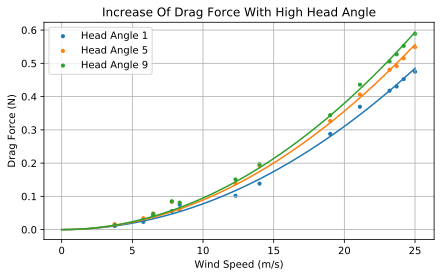

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

[ax.scatter(arm_runs[i]['speed_means'], arm_runs[i]['drag_means'],
            label='Head Angle '+str(i+1), s=10) for i in choices]
[ax.plot(x, quad_fits_arm[i]) for i in choices]
ax.legend()
ax.grid()

ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Drag Force (N)')

ax.set_title('Increase Of Drag Force With High Head Angle')

plt.savefig('sample_1.png', dpi=300)
plt.show()

## No Arms

In [12]:
choices = [0,5]

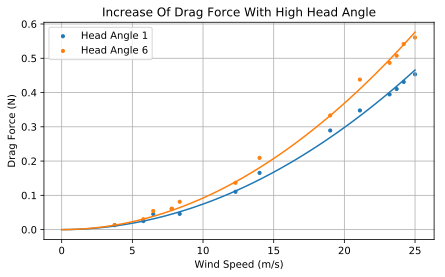

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

[ax.scatter(no_arm_runs[i]['speed_means'], no_arm_runs[i]['drag_means'],
            label='Head Angle '+str(i+1), s=10) for i in choices]
[ax.plot(x, quad_fits_no_arm[i]) for i in choices]
ax.legend()
ax.grid()

ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Drag Force (N)')

ax.set_title('Increase Of Drag Force With High Head Angle')

plt.savefig('sample_1.png', dpi=300)
plt.show()